In [71]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [15]:
path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

#scope_name = 'Tweez scope'
scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
#df_date = '2023-12-04'
#path = os.path.join(path_scope, exp_date)
vector = 'pLPT107&pLPT41'
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
# for file name
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
pos = 0

In [47]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

In [32]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')
poss = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')].Position.unique()
poss

array([ 0,  1,  2,  5,  6,  9, 14, 16, 17, 19, 21, 23, 24, 25, 28, 30, 31,
       32, 34, 35])

In [38]:
df = pd.read_excel('data_processed.xlsx')

In [17]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [49]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]

pos1


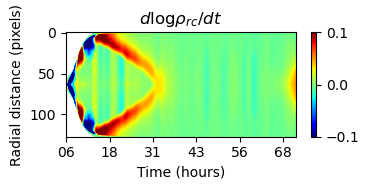

In [103]:
for j in [205]:#df_pos.index.values:
    pos = df_pos.loc[j, 'Position']
    print(f'pos{pos}')
    # open kymo
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    path = os.path.join(path_ext,scope_name,exp_date)
    #wdlkymo_rho = np.load(os.path.join(path,folder_results,f'pos{pos}','wdlkymo_rho.npy'))
       
    time_im = df_pos.loc[j, 't_im']
    time_incub = df_pos.loc[j, 't_incub']
    
    delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
    delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)
    
    # Calculate the difference
    incub_time_s = delta_im - delta_incub
    incub_time_n = incub_time_s.total_seconds() / 60
    
    time_points = np.arange(0, df_pos.loc[j, 'exp length'])*10 + incub_time_n
    time_strings = [f"{int(tp // 60):02d}" for tp in time_points]  # Show only hours

    if fluo_chns == 3:
        # Select labels at intervals (e.g., every 100 points)
        interval = 75
        indices = np.arange(0, len(time_points), interval)
        selected_time_strings = [time_strings[i] for i in indices]
        
        # Plotting
        plt.figure(figsize=(7, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[:, ::-1, 0], wdlkymo_rho[:, :, 0]]).transpose(), 
                   aspect='auto', 
                   vmin=-0.1, vmax=0.1,
                   cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (hours)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
        
        # Set x-ticks and labels
        plt.xticks(ticks=indices, labels=selected_time_strings)
        
        plt.tight_layout()
        plt.show()
    
    """
    if fluo_chns == 3:
        plt.figure(figsize=(7,2))
        plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[0:,::-1,0],wdlkymo_rho[0:,:,0]]).transpose(), 
                aspect='auto', 
                #extent=[50,215,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{rc}/dt$')
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.hstack([wdlkymo_rho[0:,::-1,1],wdlkymo_rho[0:,:,1]]).transpose(), 
                aspect='auto', 
                #extent=[50,215,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)
        plt.show()
    
    else:
        wdlkymo_rho[:,:] = warp(dlkymo_rho[:,:], map_func, {'edt':edt, 'rs':rs})
        wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan
        
        plt.figure(figsize=(7,2))
        #plt.subplot(1, 2, 1)
        plt.imshow(np.hstack([wdlkymo_rho[0:,::-1],wdlkymo_rho[0:,:]]).transpose(), 
                aspect='auto', 
                extent=[50,215,-edt.max(),edt.max()],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
        plt.colorbar()
        plt.xlabel('Time (frames)')
        plt.ylabel('Radial distance (pixels)')
        plt.title('$d\mathrm{log}\\rho_{yc}/dt$')
        plt.tight_layout()
        #plt.savefig(path_save, dpi=300)
        plt.show()
        """